# imports

In [1]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import random
import h5py
import os
import piq
from IPython.display import Image, HTML, Markdown, clear_output
from tqdm import tqdm_notebook, tnrange

!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU (UUID: GPU-6cf8054c-6c04-c256-2ebb-8137cfc2e798)


In [2]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch import nn
from IPython.display import clear_output, display, HTML
import h5py
from pathlib import Path
from tqdm import trange
import pandas as pd
import sys
sys.path.append("C:/Users/GAI/Desktop/Scott/NCA_Research")


from core_utils.plotting import *
from core_utils.utils_image import *
from core_utils.viz_train import *
from E4_PI_NCA.utils.helper import *
from E4_PI_NCA.utils.Dataset import *
from E4_PI_NCA.utils.PI_Metric import ScaledPhysicsMetrics

torch.set_default_device('cuda')

# heliper

In [3]:
def normalize_to_01(x):
    x_min, x_max = x.amin(dim=(1,2,3), keepdim=True), x.amax(dim=(1,2,3), keepdim=True)
    return (x - x_min) / (x_max - x_min + 1e-8)

def sperate_base_channels(x, base_channel_count=6):
    """將基礎通道與其他通道分離"""
    base_channels = x[:, :base_channel_count, :, :]
    other_channels = x[:, base_channel_count:, :, :]
    return base_channels, other_channels

# physics loss

In [4]:
# 索引 (Indices)
IDX_U_COMPONENTS = 6  # uped = < u >
IDX_V_COMPONENTS = 7  # vped = < v >
IDX_U_MAGNITUDE = 8  # Uped = < sqrt(u^2+v^2) >
IDX_TKE = 9  # TKEped
IDX_T_UW = 10  # Tuwped


class PhysicsLoss(nn.Module):
    """
    計算基於物理屬性的可微分損失 (PINN Loss)。

    V3 - L_u_bound:
    - 正確地將速度一致性作為單向不等式約束：
      <sqrt(u^2+v^2)> (U_pred) >= sqrt(<u>^2 + <v>^2) (reconstructed_mean_mag)
    - 懲罰 L_u_bound = relu(reconstructed_mean_mag - U_pred)
    """

    def __init__(self, alpha: float = 2.25, weights: dict = None):
        super().__init__()
        self.alpha = alpha

        if weights is None:
            self.weights = {
                "L_k_neg": 1.0,  # TKE 負值懲罰
                "L_flux": 1.0,  # 通量超界懲罰
                "L_u_bound": 1.0,  # 速度邊界不等式懲罰
            }
        else:
            self.weights = weights

        print("PhysicsLoss initialized (V3 - Physical Inequality)")
        print(f"Loss Weights: {self.weights}")

    def forward(self, pred: torch.Tensor) -> tuple[torch.Tensor, dict]:
        """
        計算總的物理損失。
        :param pred: 模型的預測輸出 (B, C, H, W)
        :return: (total_loss, loss_dict)
        """

        # --- 1. 提取所需通道 ---
        u_pred = pred[:, IDX_U_COMPONENTS]  # < u >
        v_pred = pred[:, IDX_V_COMPONENTS]  # < v >
        U_pred = pred[:, IDX_U_MAGNITUDE]  # < sqrt(u^2+v^2) >
        TKE_pred = pred[:, IDX_TKE]
        T_uw_pred = pred[:, IDX_T_UW]

        loss_dict = {}
        total_loss = torch.tensor(0.0, device=pred.device)

        # --- 2. L_k_neg (TKE 負值懲罰) ---
        L_k_neg = torch.mean(torch.relu(-TKE_pred))
        loss_dict["L_k_neg"] = L_k_neg
        total_loss += self.weights["L_k_neg"] * L_k_neg

        # --- 3. L_flux (通量超界懲罰) ---
        TKE_non_neg = torch.relu(TKE_pred)
        flux_bound_error = torch.abs(T_uw_pred) - (self.alpha * TKE_non_neg)
        L_flux = torch.mean(torch.relu(flux_bound_error))
        loss_dict["L_flux"] = L_flux
        total_loss += self.weights["L_flux"] * L_flux

        # --- 4. L_u_bound (速度邊界不等式) ---
        # 計算平均速度的速率: sqrt(<u>^2 + <v>^2)
        reconstructed_mean_mag = torch.sqrt(u_pred**2 + v_pred**2 + 1e-8)

        # 物理定律是: U_pred >= reconstructed_mean_mag
        # 違規 (Violation) 是當: reconstructed_mean_mag > U_pred
        violation = reconstructed_mean_mag - U_pred

        # 僅懲罰違規的部分 (單向約束)
        L_u_bound = torch.mean(torch.relu(violation))
        loss_dict["L_u_bound"] = L_u_bound
        total_loss += self.weights["L_u_bound"] * L_u_bound

        loss_dict["L_physics_total"] = total_loss
        return total_loss, loss_dict

# NCA model

In [5]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
IDX_GEO_MASK = 2
def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = F.pad(y, [1, 1, 1, 1], 'circular')
  y = F.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    self.w1 = nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = x[:,IDX_GEO_MASK:IDX_GEO_MASK+1]
    no_change = x[:, :6, :, :]
    updated = x + y * x[:, 2:3, :, :]
    return torch.cat([no_change, updated[:, 6:, :, :]], dim=1)

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 5856


關於loss項我有幾個問題，請更加詳細解釋:
1.U定義一致性：
$\ell$ 建議用 Huber 或 平滑 L1：對 noise 更健壯。
\ell 本身的用意是甚麼?Huber是甚麼 為甚麼要對nosie更健壯



# old compare

## main 

In [ ]:
# DATASET_IMG_SIZE = (128, 128)
# POOL_SIZE = 256
# CHANNEL_C = 24
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# dataset_dir = "../dataset_h5/train"
# loaded_dataset, dataset_city_size = load_all_cases_to_BCHW(
#     dataset_dir, target_size=DATASET_IMG_SIZE
# )
# print(loaded_dataset.shape)


# B, C, H, W = loaded_dataset.shape
# y_pool = torch.zeros((B, CHANNEL_C, H, W), device=device)
# y_pool[:, :C, :, :] = loaded_dataset
# x_pool = y_pool.clone()
# x_pool[:, 6:, :, :] = 0.0  # channel 6

# metric_calculator = ScaledPhysicsMetrics(y_pool, dataset_city_size)

torch.Size([51, 11, 128, 128])
--- Metric Baseline Calculated (Worst Score = 0) ---
MAE Max Baseline: 1.4382e-01
L_u_bound Worst Baseline: 2.9633e-01 (Perfect=5.4390e-04)
P_flux Perfect Baseline: 1.4481e-03 (Target 違規比例)
Continuity Worst Baseline: 1.0165e+00 (Perfect=1.6544e-02)


## load model

In [ ]:

#init module 
# 1. 建立一個和儲存時相同架構的實例
# (如果您的 chn 或 hidden_n 不是預設值，這裡要修改)
init_module = CA(chn=CHANNEL_C)

# 2. 定義您儲存權重的路徑
CHECKPOINT_PATH = '..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_5000.pth' # <--- 請確保這個檔案存在！

# 3. 載入狀態字典 (weights)
#    (注意：這行會報錯，如果您沒有先儲存一個 'ca_model.pth' 檔案)
try:
    checkpoint = torch.load(CHECKPOINT_PATH)
    
    # 4. 從字典中取出 'model_state_dict' 並載入到模型
    init_module.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"成功從 {CHECKPOINT_PATH} 載入模型權重。")
    print(f"(模型是從 epoch {checkpoint['epoch']} 儲存的)")

    # 5. 設置為評估模式 (用於測試)
    init_module.eval()

except FileNotFoundError:
    print(f"錯誤：找不到檢查點檔案 {CHECKPOINT_PATH}")
except Exception as e:
    print(f"載入模型時出錯：{e}")

# 4. 設置為評估模式 (非常重要！
init_module.eval()


#init module 
# 1. 建立一個和儲存時相同架構的實例
# (如果您的 chn 或 hidden_n 不是預設值，這裡要修改)
pinn_module = CA(chn=CHANNEL_C)

# 2. 定義您儲存權重的路徑
# CHECKPOINT_PATH = '..\outputs\E4-7.1_without_L_counti\E4-7.2_PI-NCA_20251031-181057\ca_model_step_5000.pth' # <--- 請確保這個檔案存在！
CHECKPOINT_PATH = '..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_5000.pth'
# 3. 載入狀態字典 (weights)
#    (注意：這行會報錯，如果您沒有先儲存一個 'ca_model.pth' 檔案)
try:
    checkpoint = torch.load(CHECKPOINT_PATH)
    
    # 4. 從字典中取出 'model_state_dict' 並載入到模型
    pinn_module.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"成功從 {CHECKPOINT_PATH} 載入模型權重。")
    print(f"(模型是從 epoch {checkpoint['epoch']} 儲存的)")

    # 5. 設置為評估模式 (用於測試)
    pinn_module.eval()

except FileNotFoundError:
    print(f"錯誤：找不到檢查點檔案 {CHECKPOINT_PATH}")
except Exception as e:
    print(f"載入模型時出錯：{e}")

# 4. 設置為評估模式 (非常重要！
pinn_module.eval()




成功從 ..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_5000.pth 載入模型權重。
(模型是從 epoch 5000 儲存的)
成功從 ..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_5000.pth 載入模型權重。
(模型是從 epoch 5000 儲存的)


CA(
  (w1): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

## compare

In [198]:
# --- 5. 執行模型比較 ---
import pandas as pd
from tqdm import trange

N_STEPS = 5000
BATCH_SIZE = 24  # 根據您的程式碼片段

# 1. 取得相同的數據 batch
batch_idx = np.random.choice(len(x_pool), BATCH_SIZE, replace=False)
target_y = y_pool[batch_idx].clone().to(device)  # 目標是不變的
batch_city_size = [dataset_city_size[i] for i in batch_idx.tolist()]
# 2. 複製三份 *初始狀態* x
x_init_only = x_pool[batch_idx].clone().to(device)
x_pinn_only = x_pool[batch_idx].clone().to(device)
x_hybrid = x_pool[batch_idx].clone().to(device)

print(f"開始 {N_STEPS} 步的比較 (Batch Size={BATCH_SIZE})...")

# 3. 儲存 metrics
results = []

# 4. 迭代
for step in trange(N_STEPS):

    # 關閉梯度計算
    with torch.no_grad():

        # --- 策略 1: Init module only ---
        x_init_only = init_module(x_init_only)

        # --- 策略 2: PINN module only ---
        x_pinn_only = pinn_module(x_pinn_only)

        # --- 策略 3: Init module THEN pinn module ---
        x_hybrid = init_module(x_hybrid)
        x_hybrid = pinn_module(x_hybrid)  # 接著跑 PINN

    # --- 計算並記錄 Metrics ---
    # (在迴圈內計算，以便觀察每一步的變化)
    metrics_init = metric_calculator(x_init_only, target_y, batch_city_size)
    metrics_pinn = metric_calculator(x_pinn_only, target_y, batch_city_size)
    metrics_hybrid = metric_calculator(x_hybrid, target_y, batch_city_size)

    # 整理並儲存
    step_record = {"step": step}

    # 將所有 metrics 加入 record
    for key, value in metrics_init.items():
        step_record[f"init_{key}"] = value.item()  # .item() 將 tensor 轉為 python 數字

    for key, value in metrics_pinn.items():
        step_record[f"pinn_{key}"] = value.item()

    for key, value in metrics_hybrid.items():
        step_record[f"hybrid_{key}"] = value.item()

    results.append(step_record)

print("比較完成。")

# 5. 轉換為 Pandas DataFrame (方便繪圖)
df_results = pd.DataFrame(results)
df_results.set_index("step", inplace=True)

# --- 6. 繪製結果 ---

print("正在繪製結果...")

# 獲取所有可比較的 metrics (排除 COMPOSITE_SCORE，單獨畫)
metric_names = [
    "data_mae_score",
    "structural_ssim_score",
    "physical_p_k_neg_score",
    "physical_p_flux_score",
    "physical_l_u_bound_score",
    "physical_continuity_score",
]

# 繪製 COMPOSITE_SCORE
plt.figure(figsize=(12, 6))
plt.plot(
    df_results.index,
    df_results["init_COMPOSITE_SCORE"],
    label="1. Init Only",
    linestyle="-",
)
plt.plot(
    df_results.index,
    df_results["pinn_COMPOSITE_SCORE"],
    label="2. PINN Only",
    linestyle="--",
)
plt.plot(
    df_results.index,
    df_results["hybrid_COMPOSITE_SCORE"],
    label="3. Init -> PINN",
    linestyle=":",
)
plt.title("Model Comparison: COMPOSITE_SCORE (Higher is Better)")
plt.xlabel("Timestep")
plt.ylabel("Score")
# plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# 繪製其他子 metrics
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()  # 轉為 1D array 方便迭代

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    ax.plot(
        df_results.index,
        df_results[f"init_{metric_name}"],
        label="Init Only",
        linestyle="-",
    )
    ax.plot(
        df_results.index,
        df_results[f"pinn_{metric_name}"],
        label="PINN Only",
        linestyle="--",
    )
    ax.plot(
        df_results.index,
        df_results[f"hybrid_{metric_name}"],
        label="Init -> PINN",
        linestyle=":",
    )

    ax.set_title(metric_name)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Score")
    # ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

plt.show()

開始 5000 步的比較 (Batch Size=24)...


  0%|          | 10/5000 [00:00<07:41, 10.82it/s]


KeyboardInterrupt: 

開始 500 步的比較 (Batch Size=24)...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:34<00:00, 14.42it/s]


比較完成。
正在繪製結果...


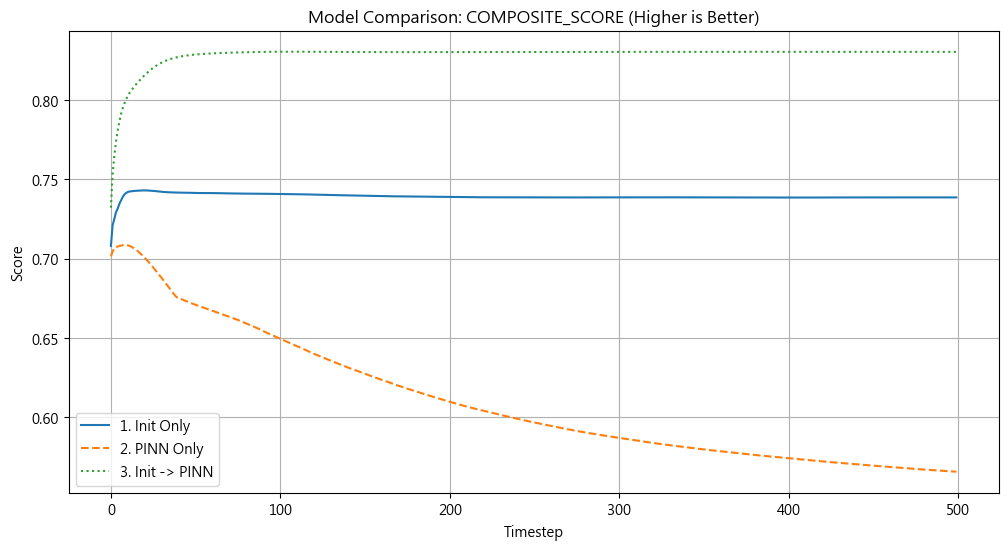

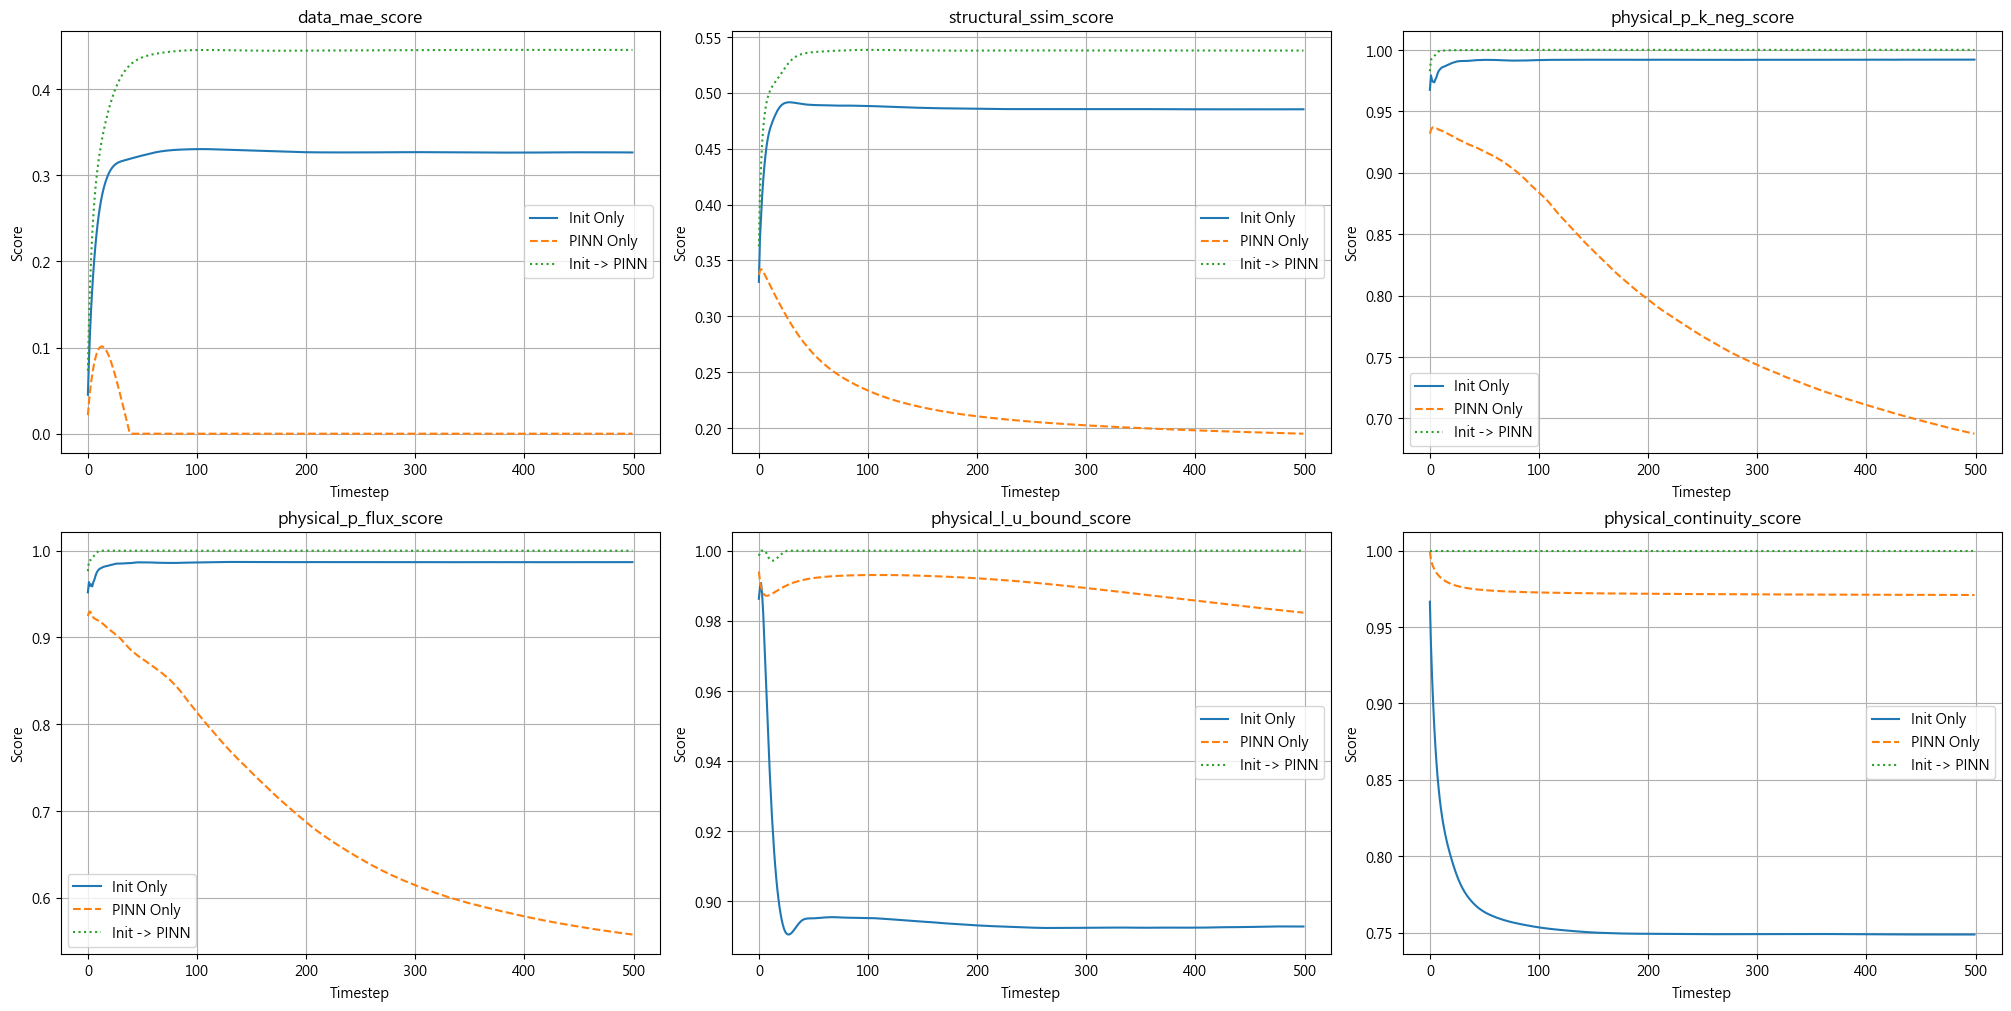

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


正在繪製 m-NCA (Hybrid) 內部修改幅度...


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


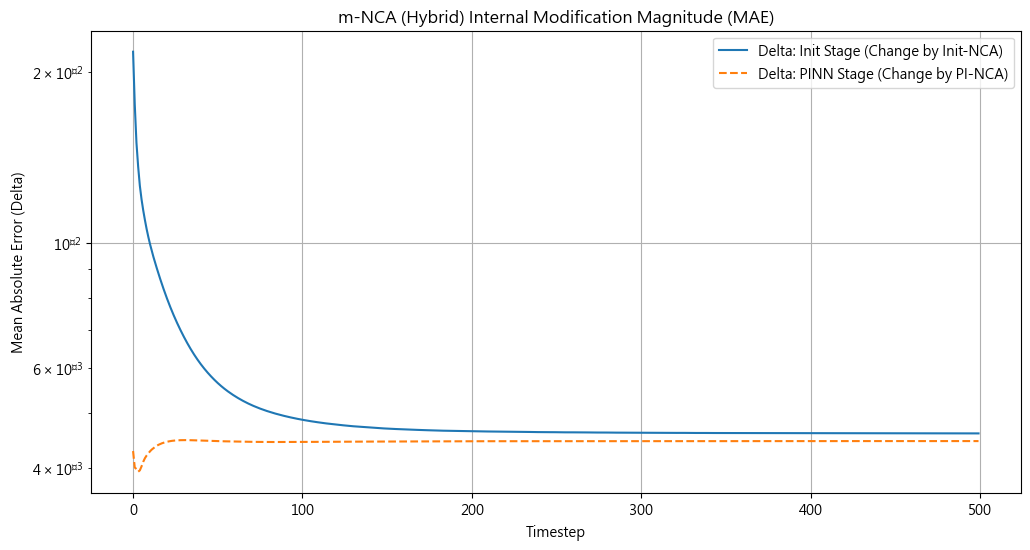

In [ ]:
# --- 5. 執行模型比較 ---

N_STEPS = 500
BATCH_SIZE = 24  # 根據您的程式碼片段

# 1. 取得相同的數據 batch
# --- [MODIFIED] --- 確保 BATCH_SIZE 與您的程式碼一致
# (您的 BATCH_SIZE 變數在程式碼中定義為 24，但您的 np.random.choice 用的是 6，
#  這裡我統一使用 BATCH_SIZE 變數)
batch_idx = np.random.choice(len(x_pool), BATCH_SIZE, replace=False) 
target_y = y_pool[batch_idx].clone().to(device)  # 目標是不變的
# --- [MODIFIED] --- 修正 city_size 的索引
# (原程式碼: dataset_city_size[i] for i in batch_idx.tolist()，
#  但 dataset_city_size 應對應 pool_city_size)
# 假設您在 create_pool 時已獲取 pool_city_size
# batch_city_size = [pool_city_size[i] for i in batch_idx.tolist()] # <--- 您的 create_pool 邏輯
# 暫時使用您原有的邏輯，但請確認 dataset_city_size 是否正確
batch_city_size = [dataset_city_size[i] for i in batch_idx.tolist()] # <--- 沿用您程式碼中的變數

# 2. 複製三份 *初始狀態* x
x_init_only = x_pool[batch_idx].clone().to(device)
x_pinn_only = x_pool[batch_idx].clone().to(device)
x_hybrid = x_pool[batch_idx].clone().to(device)

print(f"開始 {N_STEPS} 步的比較 (Batch Size={BATCH_SIZE})...")

# 3. 儲存 metrics
results = []

# 4. 迭代
for step in trange(N_STEPS):

    # 關閉梯度計算
    with torch.no_grad():

        # --- 策略 1: Init module only ---
        x_init_only = init_module(x_init_only)

        # --- 策略 2: PINN module only ---
        x_pinn_only = pinn_module(x_pinn_only)

        # --- 策略 3: Init module THEN pinn module (m-NCA) ---
        
        # --- [NEW] 1. 儲存 "before" 狀態 ---
        x_hybrid_before_init = x_hybrid.clone()

        # --- [NEW] 2. 執行 init_module ---
        x_hybrid_after_init = init_module(x_hybrid_before_init)

        # --- [NEW] 3. 計算 init_module 的 delta (修改幅度) ---
        # 我們使用 MAE 來量化 "修改幅度"
        delta_init_stage = torch.abs(
            x_hybrid_after_init - x_hybrid_before_init
        ).mean()

        # --- [NEW] 4. 執行 pinn_module ---
        x_hybrid_after_pinn = pinn_module(x_hybrid_after_init)

        # --- [NEW] 5. 計算 pinn_module 的 delta (修正幅度) ---
        delta_pinn_stage = torch.abs(
            x_hybrid_after_pinn - x_hybrid_after_init
        ).mean()

        # --- [NEW] 6. 更新 x_hybrid 以便下次迭代 ---
        x_hybrid = x_hybrid_after_pinn


    # --- 計算並記錄 Metrics ---
    # (在迴圈內計算，以便觀察每一步的變化)
    metrics_init = metric_calculator(x_init_only, target_y, batch_city_size)
    metrics_pinn = metric_calculator(x_pinn_only, target_y, batch_city_size)
    # --- [MODIFIED] --- 使用 m-NCA 的最終輸出來計算 metric
    metrics_hybrid = metric_calculator(x_hybrid, target_y, batch_city_size)

    # 整理並儲存
    step_record = {"step": step}

    # 將所有 metrics 加入 record
    for key, value in metrics_init.items():
        step_record[f"init_{key}"] = value.item()  # .item() 將 tensor 轉為 python 數字

    for key, value in metrics_pinn.items():
        step_record[f"pinn_{key}"] = value.item()

    for key, value in metrics_hybrid.items():
        step_record[f"hybrid_{key}"] = value.item()

    # --- [NEW] 儲存 Delta ---
    step_record["delta_init_stage"] = delta_init_stage.item()
    step_record["delta_pinn_stage"] = delta_pinn_stage.item()

    results.append(step_record)

print("比較完成。")

# 5. 轉換為 Pandas DataFrame (方便繪圖)
df_results = pd.DataFrame(results)
df_results.set_index("step", inplace=True)

# --- 6. 繪製結果 ---

print("正在繪製結果...")

# (Metric 繪圖程式碼保持不變...)

# 獲取所有可比較的 metrics (排除 COMPOSITE_SCORE，單獨畫)
metric_names = [
    "data_mae_score",
    "structural_ssim_score",
    "physical_p_k_neg_score",
    "physical_p_flux_score",
    "physical_l_u_bound_score",
    "physical_continuity_score",
]

# 繪製 COMPOSITE_SCORE
plt.figure(figsize=(12, 6))
plt.plot(
    df_results.index,
    df_results["init_COMPOSITE_SCORE"],
    label="1. Init Only",
    linestyle="-",
)
plt.plot(
    df_results.index,
    df_results["pinn_COMPOSITE_SCORE"],
    label="2. PINN Only",
    linestyle="--",
)
plt.plot(
    df_results.index,
    df_results["hybrid_COMPOSITE_SCORE"],
    label="3. Init -> PINN",
    linestyle=":",
)
plt.title("Model Comparison: COMPOSITE_SCORE (Higher is Better)")
plt.xlabel("Timestep")
plt.ylabel("Score")
# plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# 繪製其他子 metrics
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()  # 轉為 1D array 方便迭代

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    ax.plot(
        df_results.index,
        df_results[f"init_{metric_name}"],
        label="Init Only",
        linestyle="-",
    )
    ax.plot(
        df_results.index,
        df_results[f"pinn_{metric_name}"],
        label="PINN Only",
        linestyle="--",
    )
    ax.plot(
        df_results.index,
        df_results[f"hybrid_{metric_name}"],
        label="Init -> PINN",
        linestyle=":",
    )

    ax.set_title(metric_name)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Score")
    # ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

plt.show()


# --- 7. [NEW] 繪製 Hybrid 模型的修改幅度 (Deltas) ---
print("正在繪製 m-NCA (Hybrid) 內部修改幅度...")

plt.figure(figsize=(12, 6))
plt.plot(
    df_results.index,
    df_results["delta_init_stage"],
    label="Delta: Init Stage (Change by Init-NCA)",
    linestyle="-",
)
plt.plot(
    df_results.index,
    df_results["delta_pinn_stage"],
    label="Delta: PINN Stage (Change by PI-NCA)",
    linestyle="--",
)
plt.title("m-NCA (Hybrid) Internal Modification Magnitude (MAE)")
plt.xlabel("Timestep")
plt.ylabel("Mean Absolute Error (Delta)")
plt.legend()
plt.grid(True)
# 建議使用 log scale，因為 delta 可能會跨越好幾個數量級
plt.yscale("log") 
plt.show()

## valset

In [ ]:
DATASET_IMG_SIZE = (128, 128)
POOL_SIZE = 256
CHANNEL_C = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset_dir = "../dataset_h5/val"
loaded_dataset, dataset_city_size = load_all_cases_to_BCHW(
    dataset_dir, target_size=DATASET_IMG_SIZE
)
print(loaded_dataset.shape)


B, C, H, W = loaded_dataset.shape
y_pool = torch.zeros((B, CHANNEL_C, H, W), device=device)
y_pool[:, :C, :, :] = loaded_dataset
x_pool = y_pool.clone()
x_pool[:, 6:, :, :] = 0.0  # channel 6

metric_calculator = ScaledPhysicsMetrics(y_pool, dataset_city_size)

torch.Size([21, 11, 128, 128])
--- Metric Baseline Calculated (Worst Score = 0) ---
MAE Max Baseline: 1.5799e-01
L_u_bound Worst Baseline: 3.2814e-01 (Perfect=8.2925e-04)
P_flux Perfect Baseline: 1.3137e-03 (Target 違規比例)
Continuity Worst Baseline: 1.0148e+00 (Perfect=1.4788e-02)


## compare

開始 5000 步的比較 (Batch Size=2)...


100%|██████████| 5000/5000 [04:25<00:00, 18.81it/s]


比較完成。
正在繪製結果...


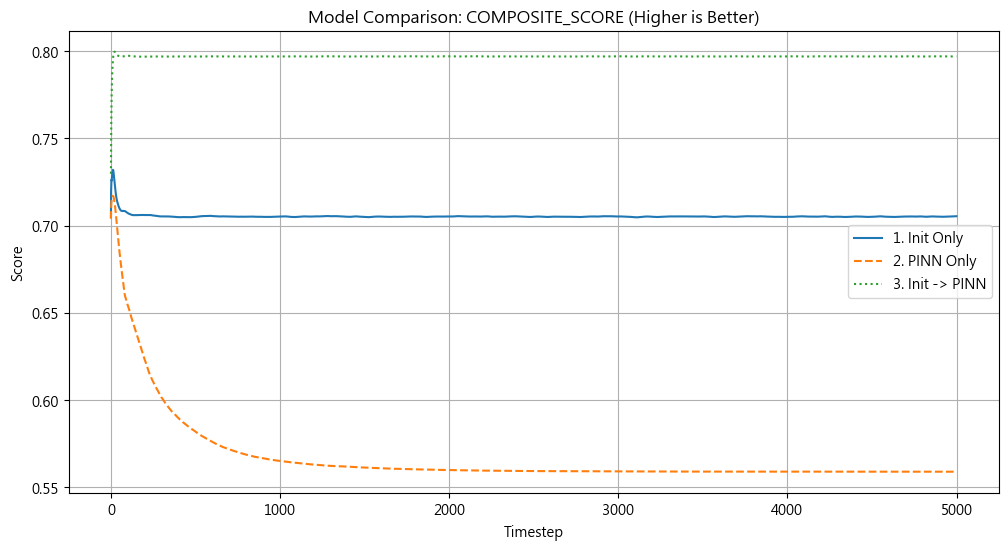

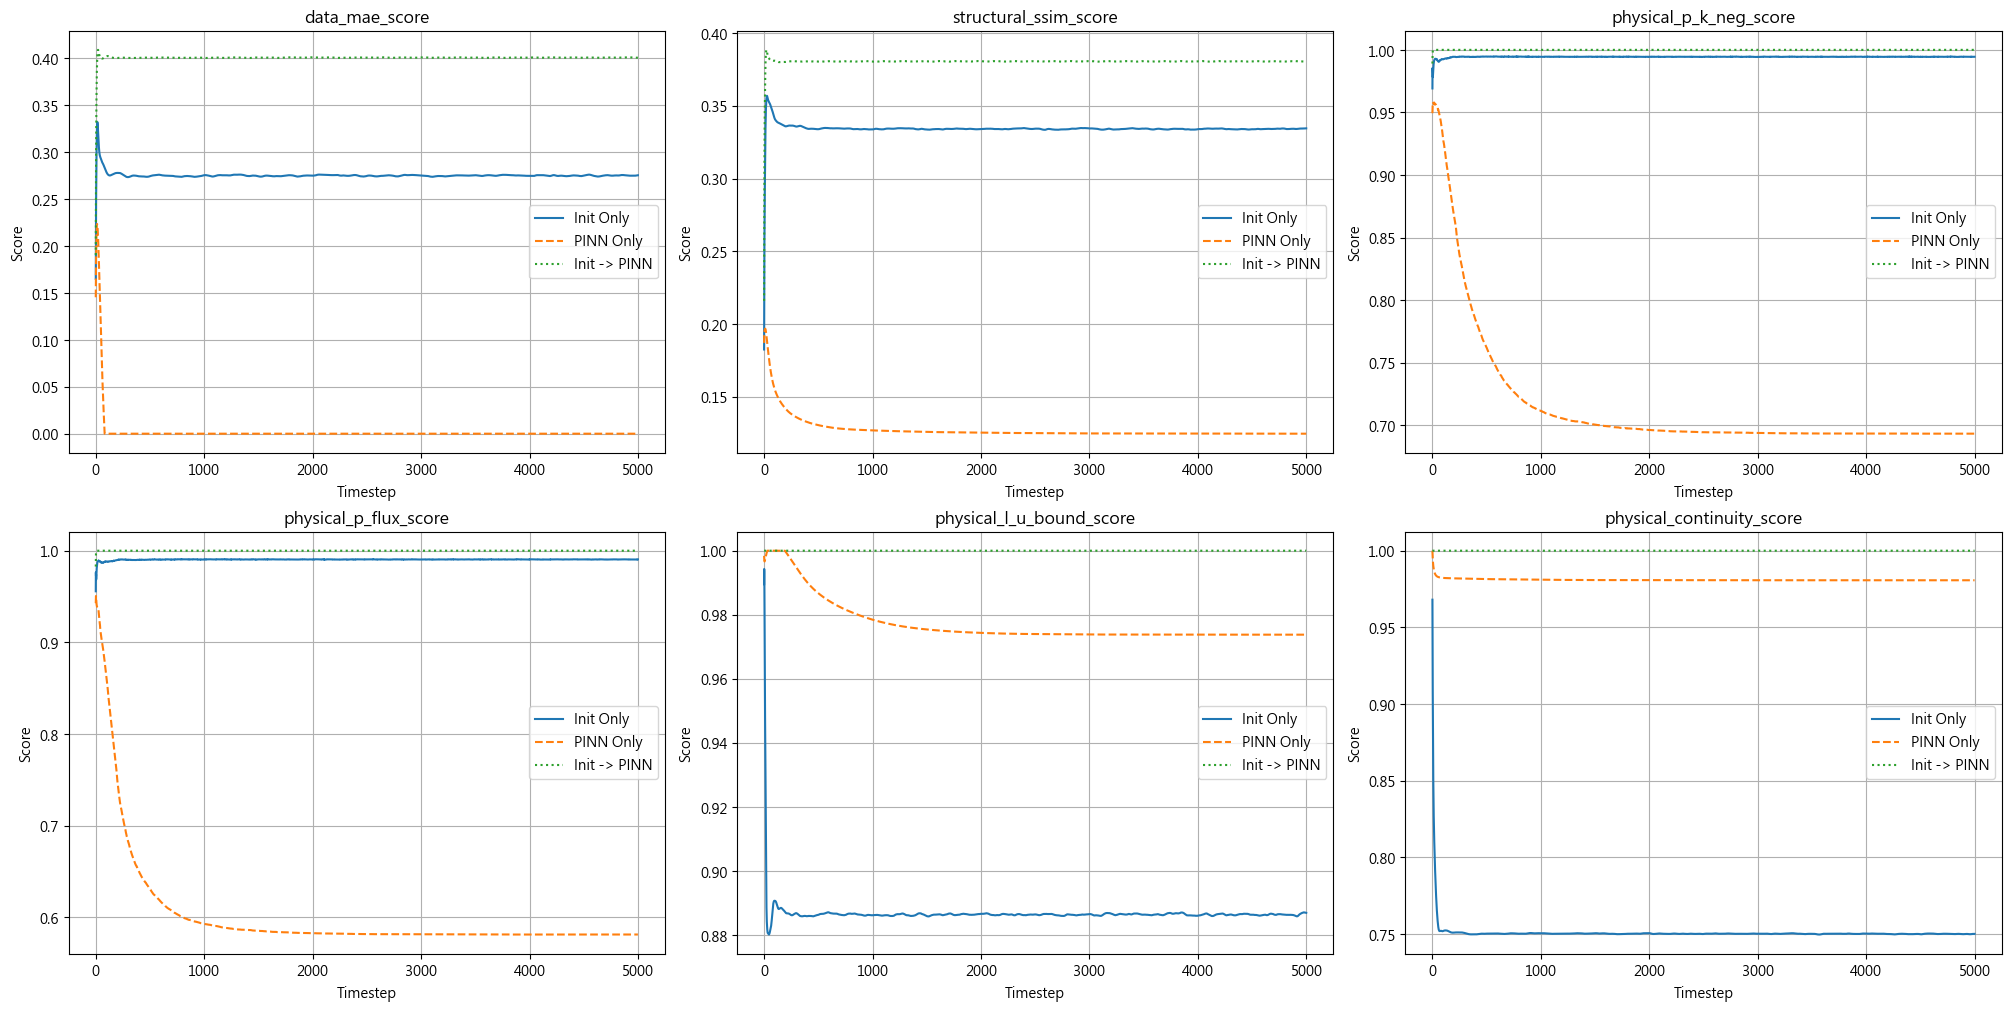

In [ ]:
# --- 5. 執行模型比較 ---
import pandas as pd
from tqdm import trange

N_STEPS = 500
BATCH_SIZE = 2  # 根據您的程式碼片段

# 1. 取得相同的數據 batch
batch_idx = np.random.choice(len(x_pool), BATCH_SIZE, replace=False)
target_y = y_pool[batch_idx].clone().to(device)  # 目標是不變的
batch_city_size = [dataset_city_size[i] for i in batch_idx.tolist()]
# 2. 複製三份 *初始狀態* x
x_init_only = x_pool[batch_idx].clone().to(device)
x_pinn_only = x_pool[batch_idx].clone().to(device)
x_hybrid = x_pool[batch_idx].clone().to(device)

print(f"開始 {N_STEPS} 步的比較 (Batch Size={BATCH_SIZE})...")

# 3. 儲存 metrics
results = []

# 4. 迭代
for step in trange(N_STEPS):

    # 關閉梯度計算
    with torch.no_grad():

        # --- 策略 1: Init module only ---
        x_init_only = init_module(x_init_only)

        # --- 策略 2: PINN module only ---
        x_pinn_only = pinn_module(x_pinn_only)

        # --- 策略 3: Init module THEN pinn module ---
        x_hybrid = init_module(x_hybrid)
        x_hybrid = pinn_module(x_hybrid)  # 接著跑 PINN

    # --- 計算並記錄 Metrics ---
    # (在迴圈內計算，以便觀察每一步的變化)
    metrics_init = metric_calculator(x_init_only, target_y, batch_city_size)
    metrics_pinn = metric_calculator(x_pinn_only, target_y, batch_city_size)
    metrics_hybrid = metric_calculator(x_hybrid, target_y, batch_city_size)

    # 整理並儲存
    step_record = {"step": step}

    # 將所有 metrics 加入 record
    for key, value in metrics_init.items():
        step_record[f"init_{key}"] = value.item()  # .item() 將 tensor 轉為 python 數字

    for key, value in metrics_pinn.items():
        step_record[f"pinn_{key}"] = value.item()

    for key, value in metrics_hybrid.items():
        step_record[f"hybrid_{key}"] = value.item()

    results.append(step_record)

print("比較完成。")

# 5. 轉換為 Pandas DataFrame (方便繪圖)
df_results = pd.DataFrame(results)
df_results.set_index("step", inplace=True)

# --- 6. 繪製結果 ---

print("正在繪製結果...")

# 獲取所有可比較的 metrics (排除 COMPOSITE_SCORE，單獨畫)
metric_names = [
    "data_mae_score",
    "structural_ssim_score",
    "physical_p_k_neg_score",
    "physical_p_flux_score",
    "physical_l_u_bound_score",
    "physical_continuity_score",
]

# 繪製 COMPOSITE_SCORE
plt.figure(figsize=(12, 6))
plt.plot(
    df_results.index,
    df_results["init_COMPOSITE_SCORE"],
    label="1. Init Only",
    linestyle="-",
)
plt.plot(
    df_results.index,
    df_results["pinn_COMPOSITE_SCORE"],
    label="2. PINN Only",
    linestyle="--",
)
plt.plot(
    df_results.index,
    df_results["hybrid_COMPOSITE_SCORE"],
    label="3. Init -> PINN",
    linestyle=":",
)
plt.title("Model Comparison: COMPOSITE_SCORE (Higher is Better)")
plt.xlabel("Timestep")
plt.ylabel("Score")
# plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# 繪製其他子 metrics
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()  # 轉為 1D array 方便迭代

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    ax.plot(
        df_results.index,
        df_results[f"init_{metric_name}"],
        label="Init Only",
        linestyle="-",
    )
    ax.plot(
        df_results.index,
        df_results[f"pinn_{metric_name}"],
        label="PINN Only",
        linestyle="--",
    )
    ax.plot(
        df_results.index,
        df_results[f"hybrid_{metric_name}"],
        label="Init -> PINN",
        linestyle=":",
    )

    ax.set_title(metric_name)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Score")
    # ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

plt.show()

# clean code

In [5]:
def random_zero_blocks_multi(tensors, block_size: int = 40, n_blocks: int = 1):
    """
    Randomly set n_blocks of size block_size x block_size to zero in multiple BCHW tensors
    at the same spatial locations.

    Args:
        tensors: list of BCHW tensors [tensor1, tensor2, tensor3]
        block_size: size of the square block to zero out
        n_blocks: number of blocks to zero randomly
    Returns:
        list of tensors with blocks zeroed (in-place)
    """
    assert len(tensors) == 3, "Expect exactly 3 tensors"
    B, C, H, W = tensors[0].shape
    for t in tensors:
        assert t.shape == (B, C, H, W), "All tensors must have the same shape"

    for _ in range(n_blocks):
        top = random.randint(0, H - block_size)
        left = random.randint(0, W - block_size)
        for t in tensors:
            t[:, :, top:top+block_size, left:left+block_size] = 0
    return tensors

In [6]:
# --------------------
# Config
# --------------------
DATASET_IMG_SIZE = (128, 128)
POOL_SIZE = 256
CHANNEL_C = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --------------------
# 1. Dataset loading
# --------------------
def load_dataset(dataset_dir, channel_c=CHANNEL_C):
    loaded_dataset, dataset_city_size = load_all_cases_to_BCHW(
        dataset_dir, target_size=DATASET_IMG_SIZE, device=device
    )
    B, C, H, W = loaded_dataset.shape

    y_pool = torch.zeros((B, channel_c, H, W), device=device)
    y_pool[:, :C] = loaded_dataset

    x_pool = y_pool.clone()
    x_pool[:, 6:] = 0.0  # mask channels

    return x_pool, y_pool, dataset_city_size


# --------------------
# 2. Load models
# --------------------
def load_models(init_ckpt, pinn_ckpt):
    init_module = CA(chn=CHANNEL_C).to(device)
    pinn_module = CA(chn=CHANNEL_C).to(device)

    ckpt1 = torch.load(init_ckpt, map_location=device)
    init_module.load_state_dict(ckpt1["model_state_dict"])
    init_module.eval()

    ckpt2 = torch.load(pinn_ckpt, map_location=device)
    pinn_module.load_state_dict(ckpt2["model_state_dict"])
    pinn_module.eval()

    return init_module, pinn_module


# --------------------
# 3. Prepare batch
# --------------------
def prepare_batch(x_pool, y_pool, dataset_city_size, batch_size):
    idx = np.random.choice(len(x_pool), batch_size, replace=False)

    x_init = x_pool[idx].clone().to(device)
    x_pinn = x_pool[idx].clone().to(device)
    x_hybrid = x_pool[idx].clone().to(device)

    y_target = y_pool[idx].clone().to(device)
    batch_city_size = [dataset_city_size[i] for i in idx.tolist()]

    return x_init, x_pinn, x_hybrid, y_target, batch_city_size


# --------------------
# 4. Run rollout evaluation
# --------------------
def run_rollout(
    init_model, pinn_model, metric_fn,
    x_init, x_pinn, x_hybrid, y_target, batch_city_size,
    steps, save_every=50
):
    """
    描述：
        執行 NCA rollout 並同時紀錄模型狀態與評估指標。
        回傳每階段 metrics + 中途所有狀態張量快照。

    參數：
        init_model        ─ 初始化訓練的 NCA 模型
        pinn_model        ─ 加入物理損失之 PINN NCA 模型
        metric_fn         ─ 評估指標計算函式 (ScaledPhysicsMetrics)
        x_init            ─ 初始狀態 (Init 模型路徑)
        x_pinn            ─ 初始狀態 (PINN 模型路徑)
        x_hybrid          ─ 初始狀態 (Hybrid: 先 Init 再 PINN)
        y_target          ─ Ground truth 目標
        batch_city_size   ─ 城市尺度參數 (供物理量換算)
        steps             ─ rollout 的總步數
        save_every        ─ 每 N 步存一次狀態

    回傳：
        df_metrics  ─ pandas DataFrame (每步的指標)
        states      ─ torch.Tensor (3, T, B, C, H, W)
                      [Init Only, PINN Only, Hybrid]
                      B=Batch, T=保存的 timestep 數
    """

    # 儲存每步 metrics 的 list
    records = []

    # 暫存每次保存的狀態
    saved_states = []   # 每次 append 三個 x 狀態 (init/pinn/hybrid)

    # timestep loop
    for step in trange(steps):
        if step  == 0:
            saved_states.append(
                (
                    x_init.clone().detach().cpu(),   # 儲存到 CPU 減輕 GPU 壓力
                    x_pinn.clone().detach().cpu(),
                    x_hybrid.clone().detach().cpu(),
                )
            )

            # if step == 0:
            #     x_init,x_pinn,x_hybrid = random_zero_blocks_multi([x_init,x_pinn,x_hybrid])
                

        # ---- NCA Rollout ----
        # 這裡關閉梯度，因為我們在 inference，不進行訓練
        with torch.no_grad():

            # Init only：只用 init 模型推進
            x_init = init_model(x_init)

            # PINN only：只用 PINN 模型推進
            x_pinn = pinn_model(x_pinn)

            # Hybrid：先 init，再 PINN
            x_hybrid = init_model(x_hybrid)
            x_hybrid = pinn_model(x_hybrid)

        # ---- 保存狀態 ----
        # 每 save_every 步保存一次張量狀態
        if step % save_every == 0:
            saved_states.append(
                (
                    x_init.clone().detach().cpu(),   # 儲存到 CPU 減輕 GPU 壓力
                    x_pinn.clone().detach().cpu(),
                    x_hybrid.clone().detach().cpu(),
                )
            )

        # ---- 指標計算 ----
        m_init   = metric_fn(x_init,  y_target, batch_city_size)
        m_pinn   = metric_fn(x_pinn,  y_target, batch_city_size)
        m_hybrid = metric_fn(x_hybrid, y_target, batch_city_size)

        # 整理成 dict
        row = {"step": step}
        for k, v in m_init.items():   row[f"init_{k}"] = v.item()
        for k, v in m_pinn.items():   row[f"pinn_{k}"] = v.item()
        for k, v in m_hybrid.items(): row[f"hybrid_{k}"] = v.item()
        records.append(row)

    # ---- 轉成 DataFrame ----
    df = pd.DataFrame(records).set_index("step")

    # ---- 將 saved_states 堆成張量 ----
    # saved_states 為 list[ (init, pinn, hybrid), ... ]
    init_list, pinn_list, hybrid_list = zip(*saved_states)

    # 最終 shape = (3, T, B, C, H, W)
    states = torch.stack([
        torch.stack(init_list),      # T, B, C, H, W
        torch.stack(pinn_list),
        torch.stack(hybrid_list),
    ])

    return df, states



# --------------------
# 5. Plot
# --------------------
def plot_metrics_overtime(df_train, df_val=None):
    metric_names = [
        "data_mae_score",
        "structural_ssim_score",
        "physical_p_k_neg_score",
        "physical_p_flux_score",
        "physical_l_u_bound_score",
        "physical_continuity_score",
    ]

    color_map = {
        "init": "C0",
        "pinn": "C1",
        "hybrid": "C2"
    }

    display_name = {
        "init": "Init-NCA module",
        "pinn": "PI-NCA module",
        "hybrid": "m-NCA"
    }

    def plot_pair(ax, df, method, col, linestyle, color):
        if df is not None and col in df.columns:
            ax.plot(df.index, df[col], linestyle=linestyle, linewidth=2, color=color)

    # ===== Legend handles =====
    model_handles = [
        plt.Line2D([], [], color=c, linewidth=2)
        for c in color_map.values()
    ]
    model_labels = [display_name[m] for m in color_map]

    style_handles = [
        plt.Line2D([], [], color="black", linestyle="--", linewidth=2),
        plt.Line2D([], [], color="black", linestyle="-", linewidth=2),
    ]
    style_labels = ["Train (--)", "Val (-)"]

    # ================= Composite =================
    fig, ax = plt.subplots(figsize=(12, 6))

    for method, color in color_map.items():
        plot_pair(ax, df_train, method, f"{method}_COMPOSITE_SCORE", "--", color)
        if df_val is not None:
            plot_pair(ax, df_val, method, f"{method}_COMPOSITE_SCORE", "-", color)

    ax.set_title("Composite Score")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Score")
    ax.grid(True)

    # Composite Legends
    L1 = ax.legend(model_handles, model_labels, loc="upper left")
    ax.add_artist(L1)
    L2 = ax.legend(style_handles, style_labels, loc="lower left")

    plt.show()

    # ================= Sub Metrics =================
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, name in enumerate(metric_names):
        ax = axes[i]

        for method, color in color_map.items():
            plot_pair(ax, df_train, method, f"{method}_{name}", "--", color)
            if df_val is not None:
                plot_pair(ax, df_val, method, f"{method}_{name}", "-", color)

        ax.set_title(name)
        ax.set_xlabel("Steps")
        ax.set_ylabel("Score")
        ax.grid(True)

    # ===== Subplot Legends =====
    # 放在整體 figure 下方
    fig.legend(
        model_handles,
        model_labels,
        loc="lower center",
        ncol=3,
        bbox_to_anchor=(0.3, -0.04),
        frameon=False
    )

    # 第二排: linestyle legend
    fig.legend(
        style_handles,
        style_labels,
        loc="lower center",
        bbox_to_anchor=(0.1, -0.04),
        frameon=False
    )

    plt.show()


def print_final_scores(df_train, df_val=None):
    metric_names = [
        "data_mae_score",
        "structural_ssim_score",
        "physical_p_k_neg_score",
        "physical_p_flux_score",
        "physical_l_u_bound_score",
        "physical_continuity_score",
    ]

    # method →顯示 label
    display_name = {
        "init": "Init-NCA_module",
        "pinn": "PI-NCA module",
        "hybrid": "m-NCA"
    }

    print("=== Composite Scores ===")
    for method in display_name.keys():
        train_col = f"{method}_COMPOSITE_SCORE"
        val_col = f"{method}_COMPOSITE_SCORE"

        final_train = df_train[train_col].iloc[-1] if train_col in df_train.columns else None
        final_val   = df_val[val_col].iloc[-1] if (df_val is not None and val_col in df_val.columns) else None

        print(f"{display_name[method]} (train): {final_train:.4f}" if final_train is not None else f"{display_name[method]} (train): N/A")
        if df_val is not None:
            print(f"{display_name[method]} (val): {final_val:.4f}" if final_val is not None else f"{display_name[method]} (val): N/A")
    print()

    print("=== Sub-metrics ===")
    for name in metric_names:
        print(f"-- {name} --")
        for method in display_name.keys():
            train_col = f"{method}_{name}"
            val_col   = f"{method}_{name}"

            final_train = df_train[train_col].iloc[-1] if train_col in df_train.columns else None
            final_val   = df_val[val_col].iloc[-1] if (df_val is not None and val_col in df_val.columns) else None

            print(f"{display_name[method]} (train): {final_train:.4f}" if final_train is not None else f"{display_name[method]} (train): N/A")
            if df_val is not None:
                print(f"{display_name[method]} (val): {final_val:.4f}" if final_val is not None else f"{display_name[method]} (val): N/A")
        print()


def plt_states_over_time(states: torch.Tensor, target: torch.Tensor, 
                         rgb_channels=[6,7,8], nth: int = 1, 
                         row_labels=None, rgb_reverse: bool = True):
    """
    Plot states and error maps for batch samples using RGB channels, showing every nth timestep,
    with row labels, horizontal separators, target, and optional RGB reverse (0 → white).
    
    Args:
        states: B x T x C x H x W
        target: C x H x W
        rgb_channels: list of 3 channel indices to use for RGB visualization
        nth: plot every nth timestep
        row_labels: list of labels for each batch sample (length=B)
        rgb_reverse: bool, if True, reverse RGB so 0 → white
    """
    B, T, C, H, W = states.shape
    assert len(rgb_channels) == 3, "rgb_channels must be a list of 3 channel indices"
    assert target.shape[0] == C and target.shape[1] == H and target.shape[2] == W

    if row_labels is None:
        row_labels = [f"B{b}" for b in range(B)]
    assert len(row_labels) == B, "row_labels length must match batch size"

    timesteps = list(range(0, T, nth))
    nT = len(timesteps)

    # ------------------------
    # target RGB plot with mask
    target_rgb = target[rgb_channels].cpu().numpy()
    target_rgb = np.transpose(target_rgb, (1,2,0))  # H x W x 3
    mask_target = target[2].cpu().numpy() > 0

    target_rgb_disp = np.ones_like(target_rgb)
    target_rgb_disp[mask_target] = target_rgb[mask_target]
    if rgb_reverse:
        target_rgb_disp = 1 - target_rgb_disp
    target_rgb_disp = np.clip(target_rgb_disp, 0, 1)

    plt.figure(figsize=(4,4))
    plt.imshow(target_rgb_disp)
    plt.title("Val City (RGB=ux,uy,Umag)")
    plt.axis('off')
    plt.show()

    # ------------------------
    # global error
    all_errors = []
    for b in range(B):
        for t in timesteps:
            img = states[b, t, rgb_channels].cpu().numpy()
            img_mean = img.mean(0)
            all_errors.append(np.abs(img_mean - target_rgb.mean(-1)))
    all_errors = np.stack(all_errors)
    e_min, e_max = all_errors.min(), all_errors.max()

    # ------------------------
    fig_height = 2*B + B*1.5
    fig, axes = plt.subplots(2*B, nT, figsize=(nT*2, fig_height), constrained_layout=True)
    if B == 1:
        axes = axes[np.newaxis, :]

    for b in range(B):
        mask = states[b, 0, 2].cpu().numpy() > 0

        # states row (RGB)
        for idx, t in enumerate(timesteps):
            ax = axes[2*b, idx] if B>1 else axes[0, idx]
            img_rgb = states[b, t, rgb_channels].cpu().numpy()
            img_rgb = np.transpose(img_rgb, (1,2,0))
            img_rgb_disp = np.ones_like(img_rgb)
            img_rgb_disp[mask] = img_rgb[mask]
            if rgb_reverse:
                img_rgb_disp = 1 - img_rgb_disp
            img_rgb_disp = np.clip(img_rgb_disp, 0, 1)
            ax.imshow(img_rgb_disp)
            ax.axis('off')

        # error row
        for idx, t in enumerate(timesteps):
            ax = axes[2*b+1, idx] if B>1 else axes[1, idx]
            img_mean = states[b, t, rgb_channels].cpu().numpy().mean(0)
            error = np.abs(img_mean - target_rgb.mean(-1))
            error_masked = np.where(mask, error, np.nan)
            im = ax.imshow(error_masked, cmap='gray_r', vmin=e_min, vmax=e_max)
            ax.axis('off')
            # MAE annotation
            mae = np.nanmean(error_masked)
            ax.text(0.95, 0.85, f"MAE: {mae:.2f}", color='blue',
                    fontsize=14, ha='right', va='bottom', transform=ax.transAxes)

        # row label
        total_rows = 2*B
        y_center = (total_rows - (2*b + 1) - 0.5)/total_rows
        fig.text(-0.06, y_center, f"{row_labels[b]}", va='center', ha='left', fontsize=14)


    # colorbar for error
    cbar = fig.colorbar(im, ax=axes, fraction=0.02, pad=0.04)
    cbar.set_label('Absolute Error')

    # timestep labels
    for idx, t in enumerate(timesteps):
        axes[0, idx].set_title(f"t={t}", fontsize=14)

    plt.show()

In [7]:
train_x_pool, train_y_pool, train_city_size = load_dataset("../dataset_h5/train")

init_model, pinn_model = load_models(
    '..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_5000.pth',
    '..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_5000.pth'
)

metric_fn = ScaledPhysicsMetrics(train_y_pool, train_city_size)

x_init, x_pinn, x_hybrid, y_target, batch_city = prepare_batch(
    train_x_pool, train_y_pool, train_city_size, batch_size=4
)

train_df, train_rollout_states = run_rollout(
    init_model, pinn_model, metric_fn,
    x_init, x_pinn, x_hybrid, y_target, batch_city,
    steps=100,
    save_every=1
)

#=========================================================
val_x_pool, val_y_pool, val_city_size = load_dataset("../dataset_h5/val")

init_model, pinn_model = load_models(
    '..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_5000.pth',
    '..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_5000.pth'
)

metric_fn = ScaledPhysicsMetrics(val_y_pool, val_city_size)

x_init, x_pinn, x_hybrid, y_target, batch_city = prepare_batch(
    val_x_pool, val_y_pool, val_city_size, batch_size=4
)

val_df, val_rollout_states = run_rollout(
    init_model, pinn_model, metric_fn,
    x_init, x_pinn, x_hybrid, y_target, batch_city,
    steps=100,
    save_every=1
)
print(val_rollout_states.shape)


print_final_scores(train_df, val_df)

plot_metrics_overtime(train_df, val_df)



NameError: name 'CA' is not defined

torch.Size([4, 24, 128, 128])
torch.Size([3, 101, 4, 24, 128, 128])


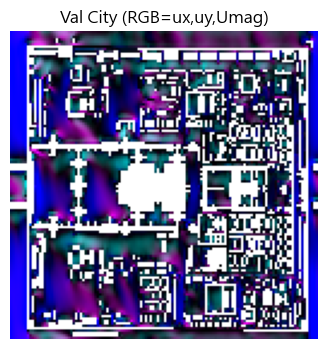

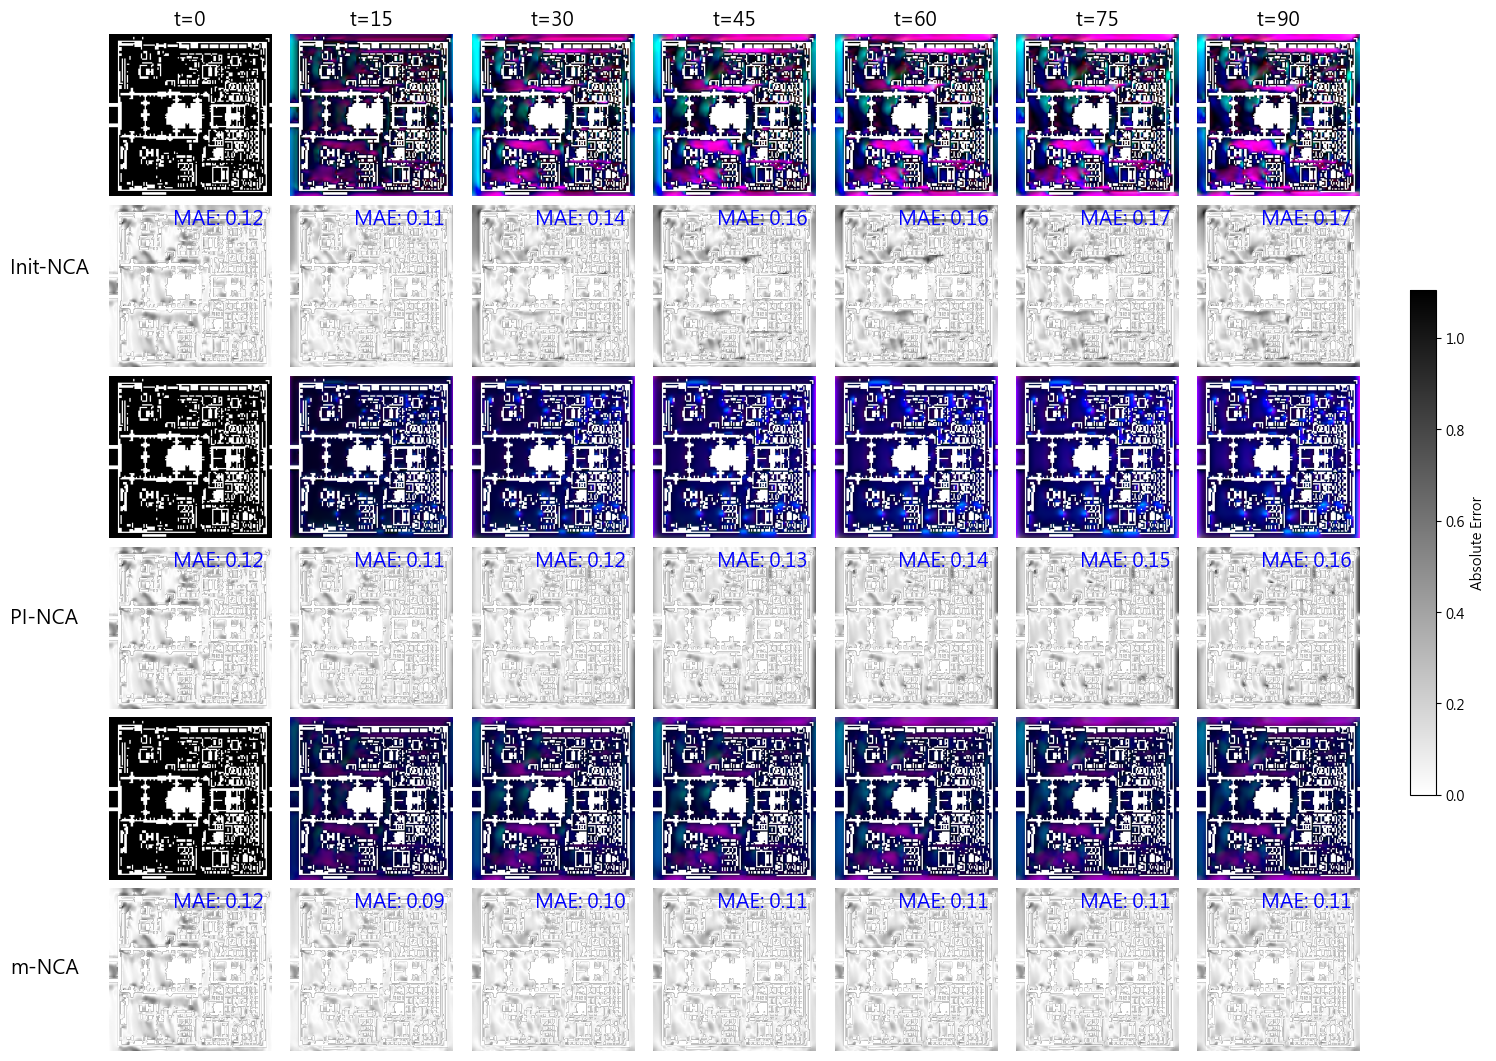

In [ ]:
print(y_target.shape)
print(val_rollout_states.shape)
row_labels = ['Init-NCA', 'PI-NCA', 'm-NCA']

sample_idx = 3
# val_rollout_states = val_rollout_states[:,:20]
plt_states_over_time(val_rollout_states[:,:,sample_idx], y_target[sample_idx], nth=15, row_labels=row_labels, rgb_reverse=False)

我想要分為一個信件兩個類別:
主類別(依照事項)
TECHNICAL
- AUTO_REPLIED
- 所有技術有關問題 包含忘記密碼帳號、無法上傳繳交、不小心withdraw、如何檢查註冊等等

Money 
- NEEDS_HUMAN 
- 所有與金錢有關的，發票收據等等

PROGRAM
- 任何與實際研討會或研討會前工作營相關活動的行事曆排程詢問或調度

LOGISTICS
- AUTO_REPLIED 
- 所有交通 住宿相關問題 visa問題

SPONSOR
- NEEDS_HUMAN 
- 與贊助商有關的問題
OTHER(GENERAL)

STAFF
- 信件中必須附加"staff"關鍵字

副類別(依照信件狀態)

AUTO_REPLIED
 若回復信心達70%以上則自動回復，line訊息通知群組
 若回復信心不及70則自動擬回復搞，line訊息通知群組交由人工確認
 若回復信心不及30則轉NEEDS_HUMAN

NEEDS_HUMAN
訊息轉交給line 群組提醒工作人員

ARCHIVE
 歷史封存紀錄

前面太久 p9 歷史9min
